In [1]:
import sys
import os
path_pipest = os.path.abspath('./')
n=0
while (not os.path.basename(path_pipest)=='pipest') and (n<4):
    path_pipest=os.path.dirname(path_pipest)
    n+=1 
if not os.path.basename(path_pipest)=='pipest':
    print("path_pipest not found. Instead: {}".format(path_pipest))
    raise ValueError("path_pipest not found.")
path_models=path_pipest+'/models'    
path_sdhawkes=path_pipest+'/sdhawkes'
path_modelling = path_sdhawkes+'/modelling'
path_resources = path_sdhawkes+'/resources'
path_lobster=path_pipest+'/lobster'
path_lobster_data=path_lobster+'/data'
path_lobster_pyscripts=path_lobster+'/py_scripts'
path_tests = path_pipest+'/tests'
path_saved_tests = path_tests+'/saved_tests'
path_perfmeas=path_tests+'/performance_measurements'
sys.path.append(path_modelling)
sys.path.append(path_resources)
sys.path.append(path_perfmeas)
import numpy as np
import pandas as pd
import pickle
import datetime
import time
import datetime
import timeit
import model as sd_hawkes_model
import plot_tools

openmp.omp_get_max_threads(): 4


In [2]:
n_states=[3,5] 
n_events = 4  # number of event types, $d_E$
n_levels = 2
upto_level = 2
time_start=0.0
time_end=time_start+1.0*60 # one minute
model = sd_hawkes_model.SDHawkes(
    number_of_event_types=n_events, list_of_n_states=n_states,
    number_of_lob_levels=n_levels, volume_imbalance_upto_level=upto_level)

In [3]:
d_E=model.number_of_event_types
d_S=model.number_of_states
print("d_E={}; d_S={}".format(d_E,d_S))

d_E=4; d_S=15


In [4]:
model.volume_enc.volimb_limits

array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ])

In [5]:
model.state_enc.df_state_enc

,st_1,st_2,one_dim_label,multidim_label
0,0,0,0,"(0, 0)"
1,0,1,1,"(0, 1)"
2,0,2,2,"(0, 2)"
3,0,3,3,"(0, 3)"
4,0,4,4,"(0, 4)"
5,1,0,5,"(1, 0)"
6,1,1,6,"(1, 1)"
7,1,2,7,"(1, 2)"
8,1,3,8,"(1, 3)"
9,1,4,9,"(1, 4)"


Assign arbitrary values to the Hawkes parameters $\nu_{e}$, $\alpha_{e',x',e}$ and $\beta_{e',x',e}$

In [6]:
nus = np.array([0.0,0.0,1.0,1.0],dtype=np.float)
alphas = np.maximum(
    np.concatenate(
        [0.2*np.ones((d_E,d_S,d_E//2),dtype=np.float),np.zeros((d_E,d_S,d_E-d_E//2),dtype=np.float)],
        axis=2),
    np.random.uniform(-0.5,0.5,size=(d_E, d_S, d_E))
)
betas = np.exp(np.minimum(2.0,np.random.uniform(0.0001,4.0,size=(d_E, d_S, d_E))))
model.set_hawkes_parameters(nus,alphas,betas)

Hawkes parameters have been set


Assign arbitrary values to the transition matrices $\phi_{e}$, for $e=0,\dots,d_E -1$

In [7]:
phis = model.state_enc.generate_random_transition_prob(n_events=d_E)
model.set_transition_probabilities(phis)

Transition probabilities have been set. Price Asymmetry = 0.5823962677164406


Assign arbitrary values to the Dirichlet parameters $\gamma_{x}$ for $x = 0,\dots,d_{S}-1$

In [8]:
gammas = np.random.uniform(low=1.5, high = 5.6,size=(d_S,2*n_levels))
model.set_dirichlet_parameters(gammas)

Producing proposal density for rejection sampling.


/home/claudio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Dirichlet parameters have been set


In [9]:
model.simulate(time_start, time_end,
               max_number_of_events=10000,
               add_initial_cond=True,store_results=True, report_full_volumes=False)

Simulation is being performed on the following machine:
 posix.uname_result(sysname='Linux', nodename='elitebook', release='5.4.0-66-generic', version='#74~18.04.2-Ubuntu SMP Fri Feb 5 11:17:31 UTC 2021', machine='x86_64')
SDHawkes.simulate: initial conditions have been acknowledged
I am adding initial conditions on the negative time axis
simulate: start of initialisation
   Number of levels in the order book: 2
   number_of_initial_events=61
 simulate: labelled_times and count have been initialised.
 simulate: intensities have been initialised.
  intensities at start: [0.00295399 0.00683871 1.00103225 1.0024998 ]
  intensity_overall at start: 2.013324759733018
simulate: start of simulation
  time_start=0.0,  time at start =0.0
 Simulation terminates. time at end =60.119398667937745,  num_of_event=288
End of simulation. run_time=0.1 seconds


In [10]:
model.store_history_of_intensities(density_of_eval_points=5000)

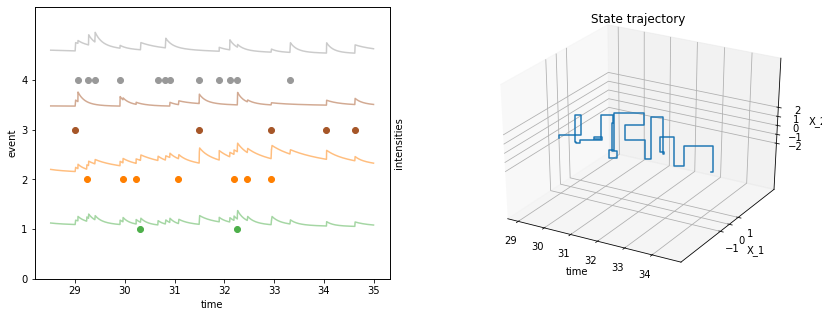

In [11]:
model.plot_events_and_states(t_0=28.5,t_1=35.0)

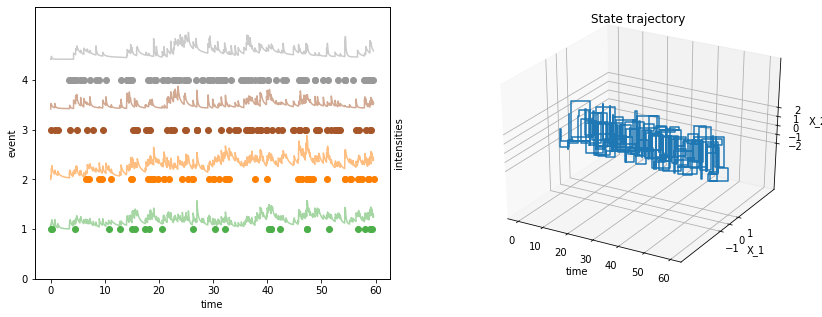

In [12]:
model.plot_events_and_states()

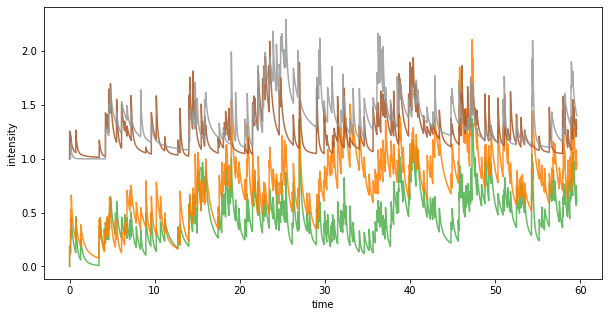

In [13]:
model.plot_intensities()

## Liquidation

In [14]:
initial_condition_times=np.array(model.simulated_times,copy=True)
initial_condition_events=np.array(model.simulated_events,copy=True)
initial_condition_states=np.array(model.simulated_states,copy=True)
initial_condition_volumes=np.array(model.simulated_volume,copy=True)

In [15]:
initial_inventory=10
liquidator_base_rate=1.0
type_of_liquid = 'constant_intensity' #constant_intensity or with_the_market or against_the_market
liquidation_control_type='fraction_of_inventory' # fraction_of_inventory or fraction_of_bid_side
liquidator_control=0.2
time_start=float(initial_condition_times[-1])
time_end=time_start+0.25*60*60

In [16]:
model.setup_liquidator(initial_inventory=initial_inventory,
                           time_start=time_start,
                           liquidator_base_rate=liquidator_base_rate,
                           type_of_liquid=type_of_liquid,
                           liquidator_control=liquidator_control)
initial_condition_events+=1

Hawkes parameters have been set
Transition probabilities have been set. Price Asymmetry = 0.649992870378875
liquidator.initial_inventory: 10.0
liquidator.type_of_liquid: constant_intensity
liquidator.control_type: fraction_of_inventory
liquidator.control: 0.2
liquidator.base_rate: 1.0
liquidator.start_time: 59.61097504989604


In [17]:
model.simulate_liquidation(
    time_end,
    initial_condition_events=initial_condition_events,
    initial_condition_states=initial_condition_states,
    initial_condition_times=initial_condition_times,
    initial_condition_volumes=initial_condition_volumes,
    verbose=False,
    report_history_of_intensities = False,
    store_results=True
)

Simulation is being performed on the following machine:
 posix.uname_result(sysname='Linux', nodename='elitebook', release='5.4.0-66-generic', version='#74~18.04.2-Ubuntu SMP Fri Feb 5 11:17:31 UTC 2021', machine='x86_64')
SDHawkes: simulate_liquidation. initial conditions have been acknowledged
simulate_liquidation. liquidator_control_type: fraction_of_inventory
  initial_invetory:10.0
   number_of_initial_events=228
initial state:1, initial event:2
simulate: labelled_times and count have been initialised.
 labelled_times.shape=(5,15,1000228), count.shape=(5,15)
simulate: intensities have been initialised.
  intensities at start: [1.         0.60620527 0.93573236 1.27640622 1.40115603]
  intensity_overall at start: 5.219499880971984
start of simulation
  time_start=59.61097504989604,  time at start =59.61097504989604
Simulation terminates. time at end =959.8965018369446,  num_of_event=4136
 liquidation terminates at time: 124.72303605612163
End of simulation: run_time=2.3 seconds


In [18]:
model.make_start_liquid_origin_of_times(delete_negative_times=False)

SDHawkes: liquidator.start_time has been set as origin of times


In [19]:
model.store_history_of_intensities()

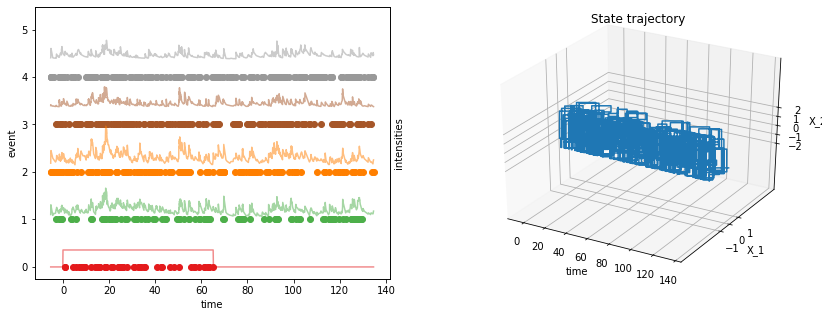

In [21]:
model.plot_events_and_states(t_0=-5.5,t_1=135.0, first_event_index=0)

## Empirical analysis of LOBSTER

In [21]:
import prepare_from_lobster as from_lobster
import lob_model

In [22]:
symbol='INTC'
date='2019-01-23'
initial_time=float(37800)
final_time=float(41400)
time_window=str('{}-{}'.format(int(initial_time),int(final_time)))

In [23]:
LOB,messagefile=from_lobster.read_from_LOBSTER(symbol,date,
                 dump_after_reading=False,
                 add_level_to_messagefile=True
                )
LOB,messagefile=from_lobster.select_subset(LOB,messagefile,
                 initial_time=initial_time,
                 final_time=final_time
                )

Given shape of orderbook: 1081948x40


/home/claudio/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


I am dropping column 6 of messagefile. Please disregard any Warning about this column
given shape of messagefile: 1081948x6
read_from_LOBSTER: time window:
  initial_time=34200.018282968
  final_time=57599.983832222
I am adding 'level' to messagefile
declare_level: check = True


In [24]:
print(messagefile.shape)
print(LOB.shape)

(188200, 8)
(188200, 42)


In [25]:
man_mf=from_lobster.ManipulateMessageFile(
     LOB,messagefile, symbol=symbol,date=date,
     aggregate_time_stamp=True,
     eventTypes_to_aggregate=[1,2,3,4,5],
     separate_directions=True,
     equiparate_45_events_with_same_time_stamp=True,
     eventTypes_to_drop_after_aggregation=[3],
     drop_5_events_with_same_time_stamp_as_4=True,
     drop_5_events_after_aggregation=True,
     tolerance_when_dropping=1.0e-8,
     clear_same_time_stamp=True,
     add_hawkes_marks=True,
     num_iter=4
)
man_ob=from_lobster.ManipulateOrderBook(
    man_mf.LOB_sdhawkes,symbol=symbol,date=date,
    ticksize=man_mf.ticksize,n_levels=man_mf.n_levels,volume_imbalance_upto_level=2)
data=from_lobster.DataToStore(man_ob,man_mf,time_origin=initial_time)
data.LOB.drop(columns=['original_idx'], inplace=True, errors='ignore')
data.messagefile.drop(columns=['original_idx', 'delta_t', 'same_time_stamp'], inplace=True, errors='ignore')
data.messagefile.columns = [col if col!='hawkes_mark' else 'hawkes_component' for col in data.messagefile.columns]
data.messagefile['hawkes_component']+=1
df_event_encoding = man_mf.event_enc.df_event_enc
df_event_encoding.columns = ['hawkes_component', 'lobster_event_type', 'direction', 'level']
df_event_encoding['hawkes_component']+=1

Initial length of the message file: 188200
ManipulateMessageFile.aggregate_time_stamp: contraction. only_4_events=False
  From 18022 lines with same time stamp, same event type and same direction, -->  to 8578 lines: 9444 lines contracted
  Initial length=188200, contracted length=178756
  Number of remaining events with same time stamp=559
I am dropping events with non-unique time stamp and event type=3, while keeping the_last of the events in every batch
Numbers of events dropped: 17
I am dropping events with non-unique time stamp and event type=5, while keeping the_last of the events in every batch
Numbers of events dropped: 44
Total number of events dropped: 61
prepare_from_lobster.separate_directions: number of occurrencies = 127 
   After separation, the average time step is 0.2320886509389001, the smallest time step is 1.2999953469261527e-07.
ManipulateMessageFile.aggregate_time_stamp: contraction. only_4_events=False
  From 282 lines with same time stamp, same event type and sa

In [26]:
df_event_encoding

,hawkes_component,lobster_event_type,direction,level
0,1,4,1,1
1,1,5,1,1
2,2,4,-1,1
3,2,5,-1,1
4,3,1,-1,1
5,3,1,-1,2
6,3,2,1,1
7,3,2,1,2
8,3,3,1,1
9,3,3,1,2


In [27]:
data.messagefile

,direction,event_type,level,price,size,time,hawkes_component
0,1,3,1,481700,100,37800.007359,3
1,-1,1,2,481900,100,37800.007505,3
2,-1,1,1,481800,100,37800.007568,3
3,-1,1,1,481800,100,37800.007572,3
4,-1,1,1,481800,100,37800.007718,3
...,...,...,...,...,...,...,...
153069,1,1,1,478300,100,41399.124310,4
153070,1,1,1,478300,100,41399.331114,4
153071,-1,1,1,478400,400,41399.595825,3
153072,1,1,1,478300,100,41399.787268,4


In [31]:
data.messagefile.drop(columns='time').describe()

,direction,event_type,level,price,size,hawkes_component
count,153074.000000,153074.000000,153074.000000,153074.000000,153074.000000,153074.000000
mean,-0.076146,1.959164,1.166704,480371.860015,290.798535,3.473157
std,0.997100,1.018335,0.394196,1126.834626,532.818752,0.544242
min,-1.000000,1.000000,0.000000,477600.000000,1.000000,1.000000
25%,-1.000000,1.000000,1.000000,480000.000000,100.000000,3.000000
50%,-1.000000,1.000000,1.000000,480300.000000,100.000000,3.000000
75%,1.000000,3.000000,1.000000,481300.000000,200.000000,4.000000
max,1.000000,5.000000,2.000000,482600.000000,9500.000000,4.000000


In [29]:
cols= [*data.LOB.columns[0:8], *['time', 'one_dim_state']]
data.LOB.loc[:,cols]

,ask_price_1,ask_volume_1,bid_price_1,bid_volume_1,ask_price_2,ask_volume_2,bid_price_2,bid_volume_2,time,one_dim_state
0,481800,100,481700,700,481900,3500,481600,3900,37800.007359,7
1,481800,100,481700,700,481900,3600,481600,3900,37800.007505,7
2,481800,200,481700,700,481900,3600,481600,3900,37800.007568,7
3,481800,300,481700,700,481900,3600,481600,3900,37800.007572,7
4,481800,400,481700,700,481900,3600,481600,3900,37800.007718,7
...,...,...,...,...,...,...,...,...,...,...
153069,478400,600,478300,1148,478500,3355,478200,2900,41399.124310,7
153070,478400,600,478300,1248,478500,3355,478200,2900,41399.331114,7
153071,478400,1000,478300,1248,478500,3355,478200,2900,41399.595825,7
153072,478400,1000,478300,1348,478500,3355,478200,2900,41399.787268,7


In [32]:
cols.remove('time')
data.LOB.loc[:,cols].describe()

,ask_price_1,ask_volume_1,bid_price_1,bid_volume_1,ask_price_2,ask_volume_2,bid_price_2,bid_volume_2,one_dim_state
count,153074.000000,153074.000000,153074.000000,153074.000000,153074.000000,153074.000000,153074.000000,153074.000000,153074.000000
mean,480422.028561,2178.962110,480311.955655,1883.589414,480522.028561,3285.499909,480211.955655,3392.120118,6.956563
std,1126.338649,1830.673051,1125.605719,1566.301197,1126.338649,907.748874,1125.605719,1261.155599,0.883536
min,477800.000000,4.000000,477600.000000,1.000000,477900.000000,439.000000,477500.000000,558.000000,0.000000
25%,480000.000000,900.000000,479900.000000,900.000000,480100.000000,2700.000000,479800.000000,2778.000000,7.000000
50%,480400.000000,1658.000000,480300.000000,1400.000000,480500.000000,3120.000000,480200.000000,3228.000000,7.000000
75%,481300.000000,2900.000000,481200.000000,2525.000000,481400.000000,3700.000000,481100.000000,3762.000000,7.000000
max,482500.000000,19900.000000,482400.000000,18014.000000,482600.000000,15439.000000,482300.000000,18114.000000,13.000000
